# Scikit-learn Example

### Load libraries

Note the difference between `import` and `from` x `import` y

In [41]:
import pandas as pd
import numpy as np

import sklearn.datasets as datasets

### Load in data

In [3]:
boston = datasets.load_boston()

### EDA

In [4]:
print(boston['DESCR'][292:1225])

        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

 


In [5]:
from scipy import stats

y = boston['target']

stats.describe(y)

DescribeResult(nobs=506, minmax=(5.0, 50.0), mean=22.532806324110677, variance=84.586723594098558, skewness=1.104810822864635, kurtosis=1.4686287722747462)

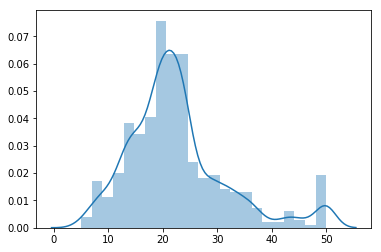

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(y)

plt.show()

## Split into training and test data sets

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
          boston['data']
        , boston['target']
        , test_size=0.33
        , random_state=42
)

### Simple Linear Regression example

ESTIMATOR.fit(predictors, response)

In [51]:
import sklearn.linear_model as lm

linear_regression = lm.LinearRegression().fit(X_train, y_train)

Model R_Square on the holdout:

In [9]:
linear_regression.score(X_test, y_test)

0.72585158182300469

Get coefficients of linear regression

In [52]:
pd.DataFrame(
      np.array([boston['feature_names'], np.round(linear_regression.coef_,5)]).T
    , columns = ['Feature','Coefficient']
)

,Feature,Coefficient
0,CRIM,-0.12806
1,ZN,0.0378
2,INDUS,0.05861
3,CHAS,3.24007
4,NOX,-16.22227
5,RM,3.89352
6,AGE,-0.01279
7,DIS,-1.42327
8,RAD,0.23451
9,TAX,-0.0082


Scikit Learn focuses on Machine Learning.  It is less concerned with summary model statistics and more about maximizing predictive power on a hold out set.  For a more traditional statistics view, you could use the `statsmodels` package.

In [62]:
from statsmodels.regression.linear_model import OLS

X_train_with_intercept = np.append(X_train,np.array([1]*X_train.shape[0]).reshape(-1,1),axis=1)

OLS(y_train, X_train_with_intercept).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     70.88
Date:                Wed, 21 Feb 2018   Prob (F-statistic):           1.47e-86
Time:                        20:11:59   Log-Likelihood:                -1012.4
No. Observations:                 339   AIC:                             2053.
Df Residuals:                     325   BIC:                             2106.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1281      0.046     -2.762      0.006      -0.219      -0.037
x2             0.0378      0.018      2.094      0.037       0.002       0.073
x3             0.0586      0.075      0.784      0.433      -0.088       0.206
x4             3.2401      1.051      3.081      0.002       1.172       5.309
x5           -16.2223      4.907     -3.306      0.001     -25.875      -6.570
x6             3.8935      0.512      7.601      0.000       2.886       4.901
x7            -0.0128      0.017     -0.771      0.441      -0.045       0.020
x8            -1.4233      0.250     -5.699      0.000      -1.915      -0.932
x9             0.2345      0.084      2.781      0.006       0.069       0.400
x10           -0.0082      0.005     -1.739      0.083      -0.017       0.001
x11           -0.9300      0.160     -5.823      0.000      -1.244      -0.616
x12            0.0119      0.003      3.512      0.001       0.005       0.019
x13           -0.5485      0.061     -9.028      0.000      -0.668      -0.429
const         33.3881      6.267      5.327      0.000      21.058      45.718
==============================================================================
Omnibus:                      112.105   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              426.846
Skew:                           1.405   Prob(JB):                     2.05e-93
Kurtosis:                       7.725   Cond. No.                     1.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Almost every estimator in `sklearn` has  `fit()`, `predict()`, and `score()` methods. This makes swapping techniques easy.

ESTIMATOR.fit(predictors, response)
ESTIMATOR.predict(predictors, response)
ESTIMATOR.score(predictors, response)

Let's fit an OLS, ridge, lasso, elasticnet, random forest, gradient boost and decision tree using the same estimator syntax.

In [64]:
import sklearn.ensemble as ens
import sklearn.tree as tree

model_list = [
      lm.LinearRegression() 
    , lm.Ridge(max_iter = 100000)
    , lm.Lasso(max_iter = 100000)
    , lm.ElasticNet(max_iter = 100000)
    , ens.RandomForestRegressor(random_state=42)
    , ens.GradientBoostingRegressor(random_state=42)
    , tree.DecisionTreeRegressor(random_state=42)
]

model_names = [type(model).__name__ for model in model_list]

fitted_models = [model.fit(X_train, y_train) for model in model_list]

model_r2 = [model.score(X_test,y_test) for model in fitted_models]

results = pd.DataFrame([model_names, model_r2], index=['Model','R2 Initial']).T

results.sort_values(['R2 Initial'], ascending=False)

,Model,R2 Initial
5,GradientBoostingRegressor,0.893198
4,RandomForestRegressor,0.812672
6,DecisionTreeRegressor,0.740223
0,LinearRegression,0.725852
1,Ridge,0.720131
3,ElasticNet,0.668769
2,Lasso,0.664381


The linear models do not fare as well as the ensemble techniques.  This is likely due to non-linear relationships in the underlying featureset.

## Preprocess data

Scikit-learn has a variety of transformers that take raw data and generate transformations that are better suited for certain algorithms.

These transformers include StandardScaler(), PCA(), Imputer(), LabelBinarizer(), PolynomialFeature(), and so much more...

Transformers are estimators too and have fit() methods to set up the transformation as well as transform() method to apply it to new data.

In [31]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
poly.fit(X_train)

X_train_transform = poly.transform(X_train)
X_test_transform = poly.transform(X_test)

In [32]:
print('By adding 2nd degree terms to our feature set we expand our featureset from ' + str(len(boston['feature_names'])) + \
      ' features to ' + str(len(poly.get_feature_names())) + '.')

fitted_models = [model.fit(X_train_transform,y_train) for model in linear_models]

model_r2 = [model.score(X_test_transform,y_test) for model in fitted_models]

results = results.T.append(pd.Series(model_r2, name='R2 Poly')).T

results.sort_values('R2 Poly', ascending=False)

By adding 2nd degree terms to our feature set we expand our featureset from 13 features to 105.


,Model,R2 Initial,R2 Poly
5,GradientBoostingRegressor,0.893198,0.887188
3,ElasticNet,0.668769,0.842125
2,Lasso,0.664381,0.838244
4,RandomForestRegressor,0.812672,0.825092
6,DecisionTreeRegressor,0.740223,0.74719
1,Ridge,0.720131,0.662576
0,LinearRegression,0.725852,0.486611


### Scikit-learn is customizable

You can even work your own transformers into the workflow.  Let's explore taking the natural log of our featureset.

In [33]:
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)

X_train_transform = np.append(X_train,transformer.transform(X_train), axis=1)
X_test_transform = np.append(X_test,transformer.transform(X_test), axis=1)

fitted_models = [model.fit(X_train_transform,y_train) for model in linear_models]

model_r2 = [model.score(X_test_transform,y_test) for model in fitted_models]

results = results.T.append(pd.Series(model_r2, name='R2 Log')).T

results.sort_values('R2 Log', ascending=False)

,Model,R2 Initial,R2 Poly,R2 Log
5,GradientBoostingRegressor,0.893198,0.887188,0.895237
4,RandomForestRegressor,0.812672,0.825092,0.824317
0,LinearRegression,0.725852,0.486611,0.822088
1,Ridge,0.720131,0.662576,0.786281
6,DecisionTreeRegressor,0.740223,0.74719,0.727383
3,ElasticNet,0.668769,0.842125,0.669214
2,Lasso,0.664381,0.838244,0.664378


# Scikit-learn is a scalable workflow

### Pipelining

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.  Pipelines are estimators too with fit(), predict() and score() methods. 


DATA --> TRANSFORM --> FIT

An example of a simple pipeline chaining polynomial transform and lasso regression together.

In [34]:
from sklearn.pipeline import Pipeline

poly = PolynomialFeatures(2)
lasso = lm.Lasso(max_iter=100000)

pipe = Pipeline(
    steps = [('poly', poly), ('lasso', lasso)]
)

pipe.fit(X_train, y_train)

print('Holdout score:' + str(pipe.score(X_test, y_test)))

Holdout score:0.838244117471


### Pipelining with GridSearchCV

The real power of pipelines is realized when using them with GridSearchCV - The beauty here is that both transformers and the model maintain data separability between the train and test of each fold in the cross-validation routine.  This ensures no data leakage in evaluating estimator performance, but allows us to refine the hyperparameters of all estimators in the pipeline.

### Optimize our DecisionTreeRegressor

DATA --> TRANSFORM --> SPLIT --> GRID_SEARCH.fit()

In [38]:
from sklearn.model_selection import GridSearchCV

dtree = tree.DecisionTreeRegressor(random_state = random_state)

pipe = Pipeline(
    steps=[
          ('poly', poly)
        , ('dtree', dtree)
    ]
)

param_grid = dict(
      dtree__criterion = ['mse','friedman_mse']
    , dtree__max_depth = [25, 50, 75, 100]
    , dtree__min_samples_leaf = [2, 3, 5, 10]
    , dtree__min_samples_split = [5,10,20]
    , poly__degree = [1,2])

optimized_pipeline = GridSearchCV(pipe, param_grid, cv=5, refit=True)
optimized_pipeline.fit(X_train, y_train)

parameters = pd.DataFrame(optimized_pipeline.cv_results_['params'])

cv_test_scores = pd.Series(optimized_pipeline.cv_results_['mean_test_score'],name='mean_test_score')

parameters.T.append(cv_test_scores).T.sort_values('mean_test_score', ascending=False).head(5)

,dtree__criterion,dtree__max_depth,dtree__min_samples_leaf,dtree__min_samples_split,poly__degree,mean_test_score
131,friedman_mse,50,3,20,2,0.755944
35,mse,50,3,20,2,0.755944
179,friedman_mse,100,3,20,2,0.755944
155,friedman_mse,75,3,20,2,0.755944
83,mse,100,3,20,2,0.755944


Let's explore the decision tree performance on our true holdout set with the optimal hyper-parameters from the GridSearch space.

In [40]:
holdout_score = round(optimized_pipeline.score(X_test,y_test),4)

print('Optimal parameter set produces a holdout score of ' + str(holdout_score) + '.')
pd.DataFrame(optimized_pipeline.best_params_,index=['Value']).T

Optimal parameter set produces a holdout score of 0.8198.


,Value
dtree__criterion,mse
dtree__max_depth,25
dtree__min_samples_leaf,3
dtree__min_samples_split,20
poly__degree,2
